https://www.kaggle.com/datasets/priyamchoksi/credit-card-transactions-dataset

In [96]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType
import seaborn as sns
import matplotlib as plt
import altair as alt
import plotly.express as px
from pyspark.sql.functions import column
from geopy.geocoders import Nominatim

In [97]:
df_path = r"F:\Datasets\CSV datasets\credit_card_transactions.csv"

In [98]:
spark = SparkSession.builder.appName('Credit_Card_Transactions').getOrCreate()

In [99]:
df = spark.read.csv(df_path, inferSchema=True, header=True)

In [100]:
df = df.drop('Unnamed: 0')

In [101]:
df.select([
    F.sum(F.when(F.col(column).isNull(), 1).otherwise(0)).alias(column) for column in df.columns
]).show()

+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+-------------+
|trans_date_trans_time|cc_num|merchant|category|amt|first|last|gender|street|city|state|zip|lat|long|city_pop|job|dob|trans_num|unix_time|merch_lat|merch_long|is_fraud|merch_zipcode|
+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+-------------+
|                    0|     0|       0|       0|  0|    0|   0|     0|     0|   0|    0|  0|  0|   0|       0|  0|  0|        0|        0|        0|         0|       0|       195973|
+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+-------------+



In [102]:
df.printSchema()

root
 |-- trans_date_trans_time: timestamp (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- merch_zipcode: integer (nullable = true)



In [103]:
df.show()

+---------------------+-------------------+--------------------+-------------+------+-----------+---------+------+--------------------+--------------------+-----+-----+-------+------------------+--------+--------------------+----------+--------------------+----------+------------------+------------------+--------+-------------+
|trans_date_trans_time|             cc_num|            merchant|     category|   amt|      first|     last|gender|              street|                city|state|  zip|    lat|              long|city_pop|                 job|       dob|           trans_num| unix_time|         merch_lat|        merch_long|is_fraud|merch_zipcode|
+---------------------+-------------------+--------------------+-------------+------+-----------+---------+------+--------------------+--------------------+-----+-----+-------+------------------+--------+--------------------+----------+--------------------+----------+------------------+------------------+--------+-------------+
|  2019-01

In [104]:
df.select(
    F.min(F.col('trans_date_trans_time')).alias('min_date'),
    F.max(F.col('trans_date_trans_time')).alias('max_date'),
).show()

+-------------------+-------------------+
|           min_date|           max_date|
+-------------------+-------------------+
|2019-01-01 00:00:18|2020-06-21 12:13:37|
+-------------------+-------------------+



In [105]:
df.agg(
    F.min("trans_date_trans_time").alias("min_date"),
    F.max("trans_date_trans_time").alias("max_date"),
    (F.unix_timestamp(F.max("trans_date_trans_time")) - F.unix_timestamp(F.min("trans_date_trans_time"))).alias(
        "time_diff_seconds")
).show()

+-------------------+-------------------+-----------------+
|           min_date|           max_date|time_diff_seconds|
+-------------------+-------------------+-----------------+
|2019-01-01 00:00:18|2020-06-21 12:13:37|         46437199|
+-------------------+-------------------+-----------------+



In [106]:
df = df.withColumn(
    'age',
    F.round((
        F.months_between(F.current_date(), F.col('dob')) / 12), 0)
        .cast(IntegerType()).alias('age')
)

In [107]:
df.show()

+---------------------+-------------------+--------------------+-------------+------+-----------+---------+------+--------------------+--------------------+-----+-----+-------+------------------+--------+--------------------+----------+--------------------+----------+------------------+------------------+--------+-------------+---+
|trans_date_trans_time|             cc_num|            merchant|     category|   amt|      first|     last|gender|              street|                city|state|  zip|    lat|              long|city_pop|                 job|       dob|           trans_num| unix_time|         merch_lat|        merch_long|is_fraud|merch_zipcode|age|
+---------------------+-------------------+--------------------+-------------+------+-----------+---------+------+--------------------+--------------------+-----+-----+-------+------------------+--------+--------------------+----------+--------------------+----------+------------------+------------------+--------+-------------+---

In [108]:
{index: column for index, column in enumerate(df.columns)}

{0: 'trans_date_trans_time',
 1: 'cc_num',
 2: 'merchant',
 3: 'category',
 4: 'amt',
 5: 'first',
 6: 'last',
 7: 'gender',
 8: 'street',
 9: 'city',
 10: 'state',
 11: 'zip',
 12: 'lat',
 13: 'long',
 14: 'city_pop',
 15: 'job',
 16: 'dob',
 17: 'trans_num',
 18: 'unix_time',
 19: 'merch_lat',
 20: 'merch_long',
 21: 'is_fraud',
 22: 'merch_zipcode',
 23: 'age'}

In [113]:
gender_avg_age = df.groupBy(
    F.col('gender')
).agg(
    F.round(F.mean('age')).alias('avg_age')
)

<Axes: xlabel='gender', ylabel='avg_age'>

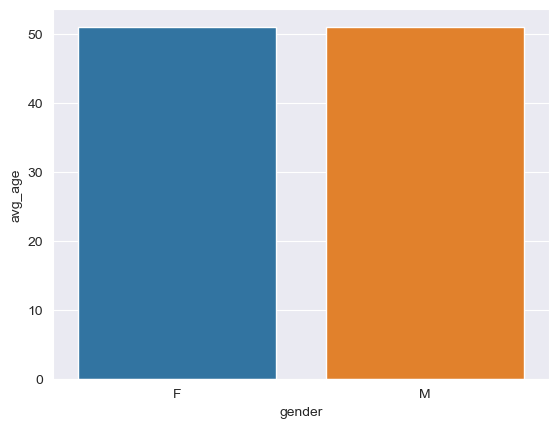

In [125]:
sns.barplot(gender_avg_age.toPandas(), x='gender', y='avg_age', hue='gender')

In [129]:
df.show(5, truncate=False)

+---------------------+----------------+----------------------------------+-------------+------+---------+-------+------+----------------------------+--------------+-----+-----+-------+---------+--------+---------------------------------+----------+--------------------------------+----------+------------------+-----------+--------+-------------+---+
|trans_date_trans_time|cc_num          |merchant                          |category     |amt   |first    |last   |gender|street                      |city          |state|zip  |lat    |long     |city_pop|job                              |dob       |trans_num                       |unix_time |merch_lat         |merch_long |is_fraud|merch_zipcode|age|
+---------------------+----------------+----------------------------------+-------------+------+---------+-------+------+----------------------------+--------------+-----+-----+-------+---------+--------+---------------------------------+----------+--------------------------------+----------+---

In [136]:
df.select([
    F.sum(F.when(F.col(column).isNull(), 1).otherwise(0)).alias(column) for column in df.columns]).show()

+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+-------------+---+
|trans_date_trans_time|cc_num|merchant|category|amt|first|last|gender|street|city|state|zip|lat|long|city_pop|job|dob|trans_num|unix_time|merch_lat|merch_long|is_fraud|merch_zipcode|age|
+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+-------------+---+
|                    0|     0|       0|       0|  0|    0|   0|     0|     0|   0|    0|  0|  0|   0|       0|  0|  0|        0|        0|        0|         0|       0|       195973|  0|
+---------------------+------+--------+--------+---+-----+----+------+------+----+-----+---+---+----+--------+---+---+---------+---------+---------+----------+--------+-------------+---+



In [142]:
df = df.fillna({
    'amt': 0,
    'zip': 0,
    'city': 'Unknown',
    'merch_zipcode': 0,
})

In [145]:
from pyspark.sql.types import DateType, TimestampType

In [149]:
df = df.withColumns({
    'trans_date_trans_time': F.col('trans_date_trans_time').cast(TimestampType()),
    'dob': F.col('dob').cast(DateType())
})

In [159]:
df.groupBy('trans_num', 'unix_time').count().filter(
    F.col('count') > 1
).show(truncate=False)

+---------+---------+-----+
|trans_num|unix_time|count|
+---------+---------+-----+
+---------+---------+-----+



In [167]:
df = df.withColumn(
    'cc_num_masked',
    F.concat(F.lit('*********'), F.substring('cc_num', -4, 4))
)